# Финальное задание по классификации изображений

В рамках скринкастов к модулям по классифиикации изображений мы изучили:

1. Как работать с датасетами с помощью pytorch

2. Как построить модель с нуля с помощью pytorch

3. Как можно использовать уже готовые модели

4. Как обучить модель с нуля с помощью pytorch

5. Как можно использовать предобученные модели

6. Какие есть оптимальные способы дообучения модели под задачу

Итого, мы пришли к пониманию того, каким оптимальным решить задачу классификации дообучением готовых моделей.

В рамках задания мы попробуем теперь упростить сам код для дообучения.

Для расширения кругозора на досуга можете изучить подробнее, как выглядит полный код, подходящий для обучения моделей из семейства ResNet с нуля на датасете ImageNet в официальном репозитории c примерами использования [pytorch](https://github.com/pytorch/examples/blob/master/imagenet/main.py).

Вкратце там находится сильно расширенная версия пайплайна обучения, который мы делали во втором ноутбуке по классификации изображений и со всем отслеживанием метрик и логированием код занимает больше 400 строк. В нашем случае это было меньше 100 строк.

Но может есть способ не повторять каждый раз все эти 100-400 строк для решения простой задачи классификации?

Ответ на вопрос положительный, и на помощь нам приходят фреймворки уже поверх базовых фреймоврков pytorch и torchvision.

В рамках этого задания мы воспользуемся фреймворком pytorch-lightning для решения простой задачи классификации.

Идея его в том, чтобы реализовывать только уникальные для модели и задачи вещи, а рутинные вложенные циклы фреймворк берет на себя:

<video controls src="lightning.mp4" width="100%" />

Импортируем как обычно вспомогательные библиотеки:

In [ ]:
%matplotlib inline
%load_ext tensorboard

import os
import random
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import pytorch_lightning as pl
import torch
import torchvision

print(pl.__version__)
print(torch.__version__)
print(torchvision.__version__)

BATCH_SIZE = 16

1.4.4
1.9.0+cu111
0.10.0+cu111


## Подготовка данных

Как и в скринкастах, возьмьем еще один пример датасета с Kaggle — [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition).

Задача состоит в том, чтобы определять тип цветка (один из 5) по фотографии (всего их в датасете чуть больше 4317).

In [ ]:
!ls flowers/

daisy  dandelion  rose	sunflower  tulip


In [ ]:
!find flowers/ -type f | wc -l

4317


Создайте объекты датасетов для обучения и валидации (на которую оставьте 512 изображений):

In [ ]:
train_dataset = ...
valid_dataset = ...

print(len(train_dataset), len(valid_dataset))

3805 512


Посмотрим на примеры из обучения и валидации:

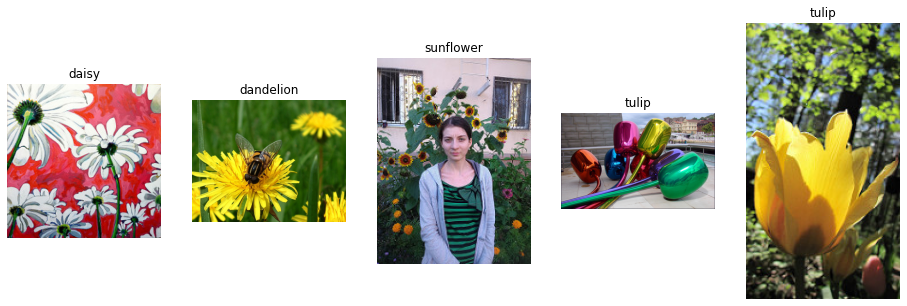

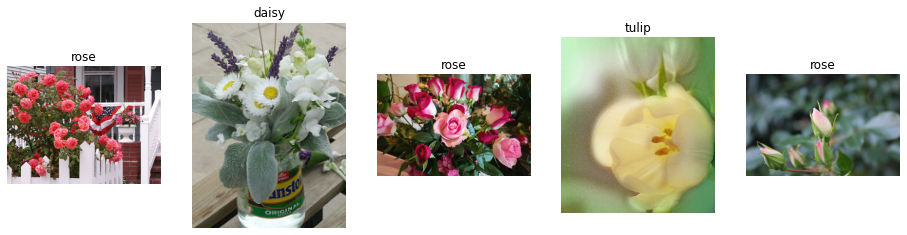

In [ ]:
def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title(random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()

plot_samples(train_dataset)
plot_samples(valid_dataset)

Определите также даталоадеры для обучения и валидации:

In [ ]:
from torchvision import transforms

train_loader = ...
valid_loader = ...

## Обучение модели

Для обучения модели с помощью pytorch-lighning необходимо определить обучающий модуль класса `LightningModule`.

Внутри он из себя представляет все тот же `nn.Module`, но с дополнительным багажом полезных возможностей.

Давайте определим такой модуль для нашей задачи, предполагая делать файн-тюнинг предобученной ResNet-34:

In [ ]:
from torch.nn import functional as F
from torch.utils.data import DataLoader


class FlowersModel(pl.LightningModule):

    def __init__(self):
        super().__init__()

        # используем предобученную модель ResNet-34
        self.net = ...
        # замораживаем веса
        for parameter in self.net.parameters():
            ...
        # заменяем полносвязный слой на новый под нужное количество классов
        self.net.fc = ...

    # вызов модуля
    def forward(self, x):
        return self.net(x)

    # шаг обучения
    def training_step(self, batch, batch_nb):
        images, target = batch
        output = self(images)
        # используем "функциональную" версию функции потерь вместо инстанцирования модуля
        loss = F.cross_entropy(output, target)
        with torch.no_grad():
            top1 = torch.mean((output.argmax(1) == target).float()).item()

        # логируем метрики — они будут как в прогрессбаре внизу, так и в отдельной директории
        self.log('loss/train', loss, on_step=False, on_epoch=True)
        self.log('top1/train', top1, on_step=False, on_epoch=True, prog_bar=True)

        # нужно вернуть основное значение лосса (функции потерь)
        return loss

    def validation_step(self, batch, batch_idx):

        output = ...
        loss = ...
        top1 = ...

        self.log('loss/val', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('top1/val', top1, on_step=False, on_epoch=True, prog_bar=True)

    # используемые оптимизаторы
    def configure_optimizers(self):
        return torch.optim.SGD(self.net.parameters(), lr=1e-2, weight_decay=1e-4)

И запустим процесс обучения с помощью "обучателя" `pl.Trainer`:

In [ ]:
# Инициализируем модуль
flowers_model = FlowersModel()

# Инициализируем обучатель
trainer = pl.Trainer(
    # используем 1 видеокарту
    gpus=1,
    # обучаем в течение 30-ти эпох
    max_epochs=30,
    # обновляем прогрессбар каждые 10 итераций
    progress_bar_refresh_rate=10
)

# Обучаем модель обучателем на нашем датасете
trainer.fit(flowers_model, train_loader, valid_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | net  | ResNet | 21.3 M
--------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.149    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Всего несколько строчек и процесс обучения запущен, прологирован и завершен!

## Анализ обученной модели

По умолчанию наш трейнер записывает логи обучения в формате TensorBoard в директории `lightning_logs/`.

Давайте запустим расширение `tensorboard` для ноутбука, чтобы отобразить его прямо здесь:

(скриншот того, что здесь ожидается увидеть, приведен ниже)

In [ ]:
%tensorboard --logdir lightning_logs

![tensorboard](./tensorboard.png)

Видим, что и на обучении и на валидации было достигнуто качество в районе 95%!

## Предсказание построенной моделью

Загрузим фото розы из интернета:

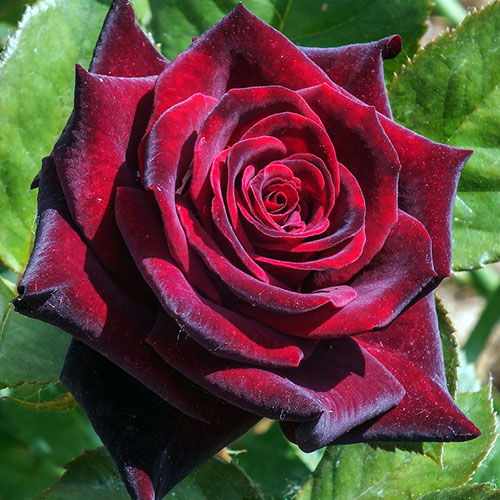

In [ ]:
from PIL import Image

image = Image.open("rose.jpg")

image

Сделайте предсказание для нашего изображение с помощью обученной модели:

In [ ]:
<...>(image)

predicted = ...

Какому классу соответствует предсказание?

In [ ]:
...

'rose'

Какие можем сделать выводы?